# Project Proposal: Study of the Links Between Gold Market and US Debt & FED Rates

### This project aims to explore the relationships between the gold market, US debt, and Federal Reserve (FED) rates using machine learning techniques. By analyzing historical data and applying various ML models, we hope to uncover patterns and insights that can inform portfolio management and trading strategies.

Authors : Paul-Antoine FRUCHTENREICH & Bilal BENHANA 
Date : 2024

## API and package init

In [ ]:
#pip install kagglehub
#pip install seaborn
#pip install statsmodels

In [4]:
import requests
import json
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import datetime

In [5]:
# Dictionary to map dataset IDs to their corresponding endpoints

dataset_endpoints = {
    'debt_to_penny': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/debt_to_penny',
    'average_interest_rate': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates',
    'tips_cpi': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/tips_cpi_data_detail'
}

def fetch_data(dataset_id, start_date, end_date, sort='record_date'):
    """
    Fetch data from the specified dataset endpoint with optional parameters.

    :param dataset_id: str, ID of the dataset to fetch (e.g., 'debt_to_penny', 'average_interest_rate', 'tips_cpi')
    :param start_date: str, start date for the data in 'YYYY-MM-DD' format
    :param end_date: str, end date for the data in 'YYYY-MM-DD' format
    :param sort: str, field to sort the data by (default is 'record_date')
    :return: dict, JSON response from the API
    """
    days = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - datetime.datetime.strptime(start_date, '%Y-%m-%d')).days
    
    if days > 10000:
        raise ValueError(f"The maximum range of data that can be fetched is 10000 days (approximately 27 years). Here, the range is {days} days. (approximately {days//365} years).")

    if dataset_id not in dataset_endpoints:
        raise ValueError(f"Invalid dataset_id. Available options are: {list(dataset_endpoints.keys())}")

    url = dataset_endpoints[dataset_id]
    params = {
        'filter': f'{sort}:gte:{start_date},{sort}:lte:{end_date}',
        'sort': sort,
        'page[number]': 1,
        'page[size]': days
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code} - {response.text}")

    df = pd.DataFrame(json.loads(response.text)['data'])
    return df

# Example usage:

"""

debt_to_penny_df = fetch_data('debt_to_penny', '2020-01-01', '2021-01-01')
average_interest_rate_df = fetch_data('average_interest_rate', '2020-01-01', '2021-01-01')
tips_cpi_df = fetch_data('tips_cpi', '1998-01-01', '2020-01-01', sort='original_issue_date')

"""

"\n\ndebt_to_penny_df = fetch_data('debt_to_penny', '2020-01-01', '2021-01-01')\naverage_interest_rate_df = fetch_data('average_interest_rate', '2020-01-01', '2021-01-01')\ntips_cpi_df = fetch_data('tips_cpi', '1998-01-01', '2020-01-01', sort='original_issue_date')\n\n"

## Load gold prices and US debt data

### Load the gold price data into a DataFrame

In [6]:
# Download kaggle dataset of gold price from 1979 to 2022 on a daily basis
path = kagglehub.dataset_download("jishnukoliyadan/gold-price-1979-present")

# The gold with volume, open, high, low, close price  on a daily basis from 1994 to 2021
path_2 = kagglehub.dataset_download("nward7/gold-historical-datasets")

In [ ]:
gold_data = pd.read_csv(path + "/Daily_Gold_Price_on_World.csv")
gold_data_usd = gold_data[["Date", "US dollar (USD)"]]
gold_data_usd['Date'] = pd.to_datetime(gold_data_usd['Date'])
gold_data_usd = gold_data_usd.rename(columns={"US dollar (USD)": "usd_price"})
gold_data_usd = gold_data_usd.set_index('Date')

In [ ]:
gold_data_2 = pd.read_csv(path_2 + "/Gold_Daily .csv")
gold_data_2['Date'] = pd.to_datetime(gold_data_2['Date'])
gold_data_2 = gold_data_2.rename(columns={"Change %": "Daily_return", "Vol":"Volume"})
gold_data_2 = gold_data_2.set_index('Date')
# convert the volume to numeric
gold_data_2["Volume"] = gold_data_2["Volume"].str.replace("K", "e3")
gold_data_2["Volume"] = pd.to_numeric(gold_data_2["Volume"], errors='coerce')
gold_data_2.dropna()

### Load US debt into a dataset

In [11]:
# Fetching US debt from 1993 to 2023
debt_to_penny_df_1 = fetch_data('debt_to_penny', '1993-01-01', '2003-01-01')
debt_to_penny_df_2 = fetch_data('debt_to_penny', '2003-01-01', '2023-01-01')
debt_to_penny_df = pd.concat([debt_to_penny_df_1, debt_to_penny_df_2])

# keep only the relevant columns
debt_to_penny_df = debt_to_penny_df[['record_date', 'tot_pub_debt_out_amt']]

# convert  tot_pub_debt_out_amt to numeric in trillions
debt_to_penny_df['record_date'] = pd.to_datetime(debt_to_penny_df['record_date'])
debt_to_penny_df['tot_pub_debt_out_amt'] = pd.to_numeric(debt_to_penny_df['tot_pub_debt_out_amt']) / 1e12  # convert to trillions $
debt_to_penny_df = debt_to_penny_df.set_index('record_date')


### Features Engineering

In [ ]:
# compute daily returns
gold_data_usd['daily_return'] = gold_data_usd['usd_price'].pct_change()
debt_to_penny_df['daily_return'] = debt_to_penny_df['tot_pub_debt_out_amt'].pct_change()

# compute daily variation
gold_data_usd['daily_variation'] = gold_data_usd['usd_price'].diff()
debt_to_penny_df['daily_variation'] = debt_to_penny_df['tot_pub_debt_out_amt'].diff()

# compute 7d - 28d - 90d - 365 annualized volatility for gold and debt
gold_data_usd['volatility_7d'] = gold_data_usd['daily_return'].rolling(window=7).std() * ((365/7)**0.5)
gold_data_usd['volatility_28d'] = gold_data_usd['daily_return'].rolling(window=28).std() * ((365/28)**0.5)
gold_data_usd['volatility_90d'] = gold_data_usd['daily_return'].rolling(window=90).std() * ((365/90)**0.5)
gold_data_usd['volatility_365d'] = gold_data_usd['daily_return'].rolling(window=365).std()

## Plots

### Gold Price

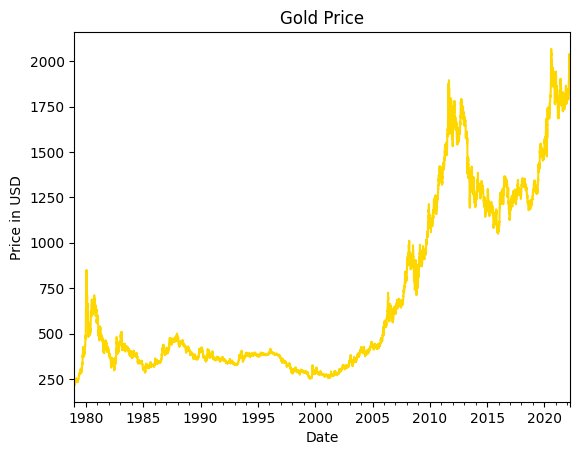

In [14]:
gold_data_usd['usd_price'].plot(color='gold')
plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

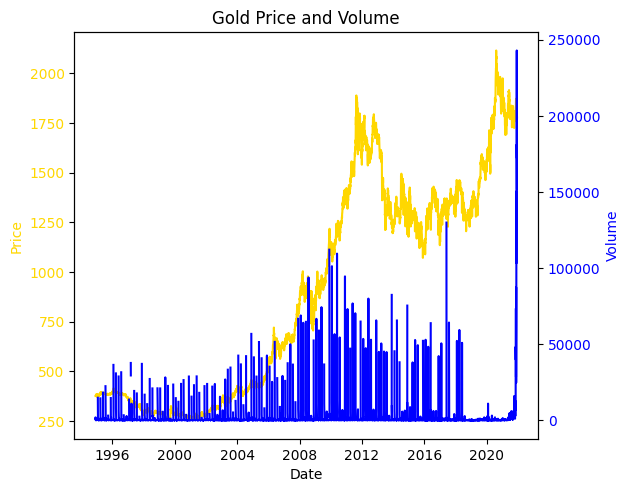

In [81]:
# plot the gold_data_2 price with volume 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='gold')
ax1.plot(gold_data_2.index, gold_data_2['Price'], color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Volume', color='blue')  # we already handled the x-label with ax1
ax2.plot(gold_data_2.index, gold_data_2['Volume'], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Gold Price and Volume')
plt.show()


### US Debt

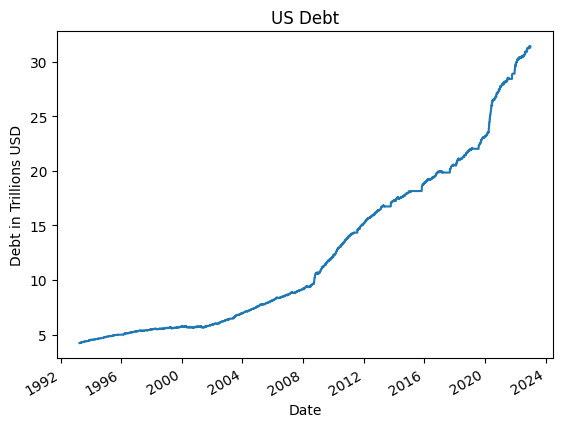

In [15]:
debt_to_penny_df['tot_pub_debt_out_amt'].plot()

plt.title('US Debt')
plt.xlabel('Date')
plt.ylabel('Debt in Trillions USD')
plt.show()

### US Debt aside Gold Price during some key periods

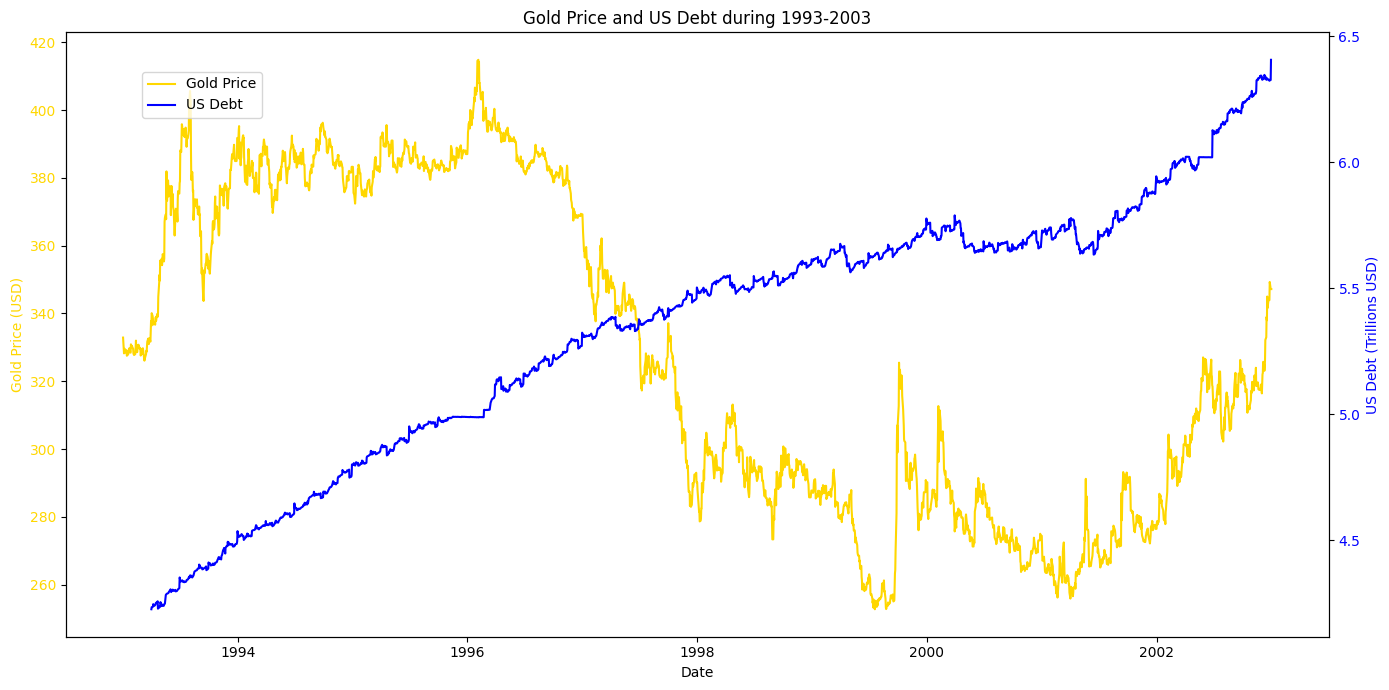

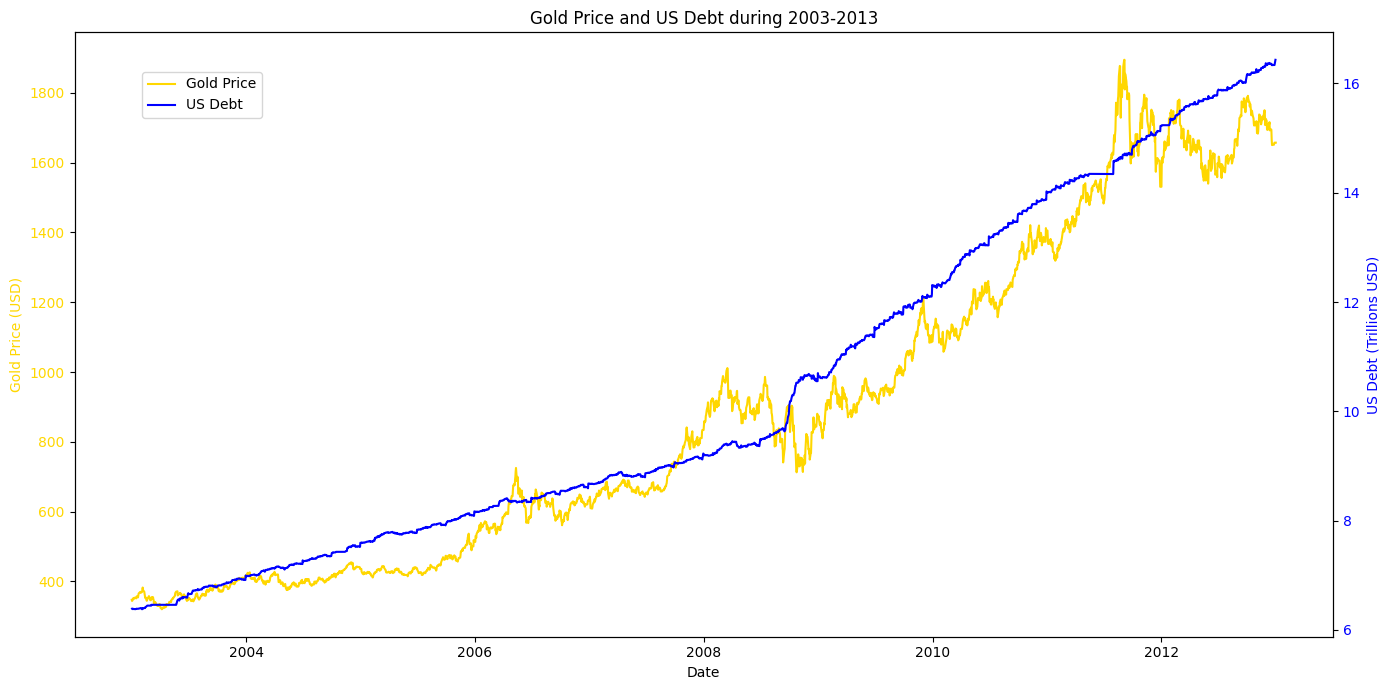

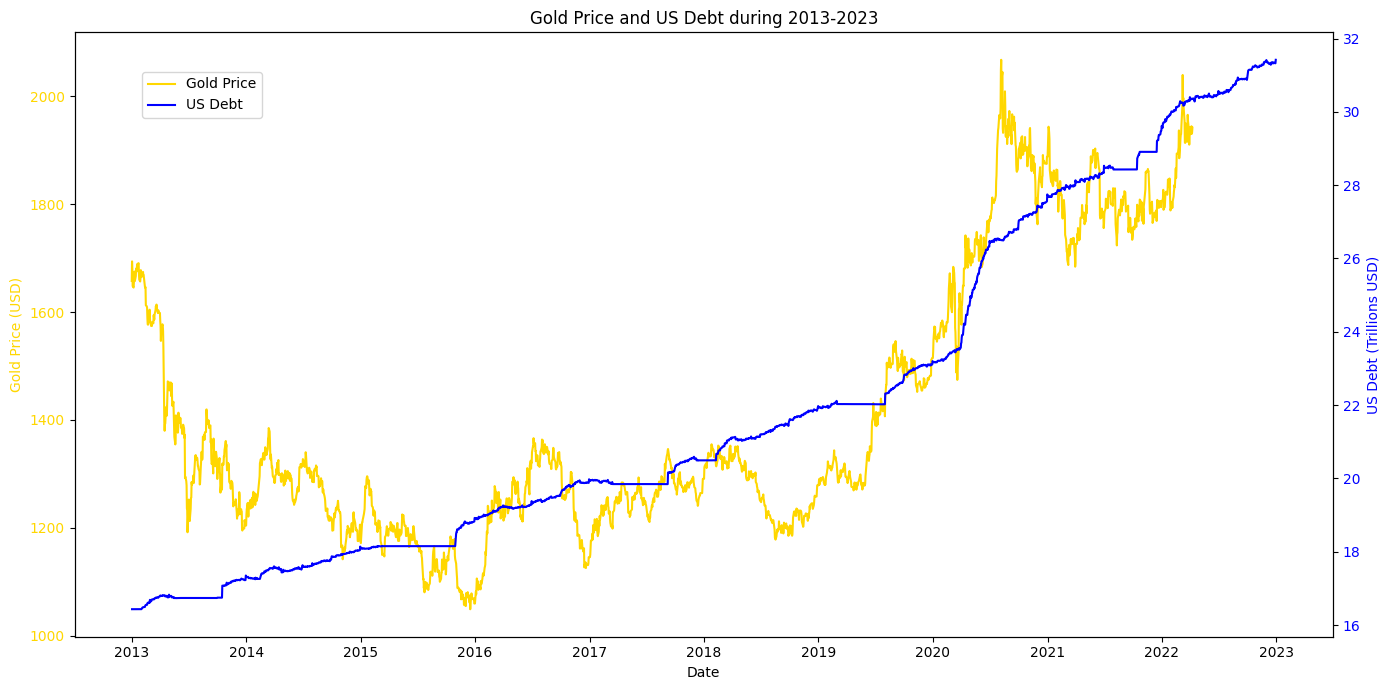

In [16]:
def plot_aside(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.plot(gold_data_usd[start_date:end_date].index, gold_data_usd[start_date:end_date]['usd_price'], color='gold', label='Gold Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Price (USD)', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_to_penny_df[start_date:end_date].index, debt_to_penny_df[start_date:end_date]['tot_pub_debt_out_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Gold Price and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

# Define some periods of interest
decenal_periods = {
    '1993-2003': ('1993-01-01', '2003-01-01'),
    '2003-2013': ('2003-01-01', '2013-01-01'),
    '2013-2023': ('2013-01-01', '2023-01-01')
}

# Define all the crisis periods since 1993
crisis_periods = {
    '1997-1998 Asian Financial Crisis': ('1997-07-01', '1998-12-31'),
    '2000-2002 Dot-Com Bubble Burst': ('2000-03-01', '2002-12-31'),
    '2007-2008 Global Financial Crisis': ('2007-07-01', '2008-12-31'),
    '2010-2012 European Debt Crisis': ('2010-01-01', '2012-12-31'),
    '2015-2016 Chinese Stock Market Crash': ('2015-06-01', '2016-12-31'),
    '2019-2020 COVID-19 Pandemic': ('2019-12-01', '2020-12-31')
}

# Example usage
for period_name, (start_date, end_date) in decenal_periods.items():
    plot_aside(start_date=start_date, end_date=end_date, crisis_periods=period_name)

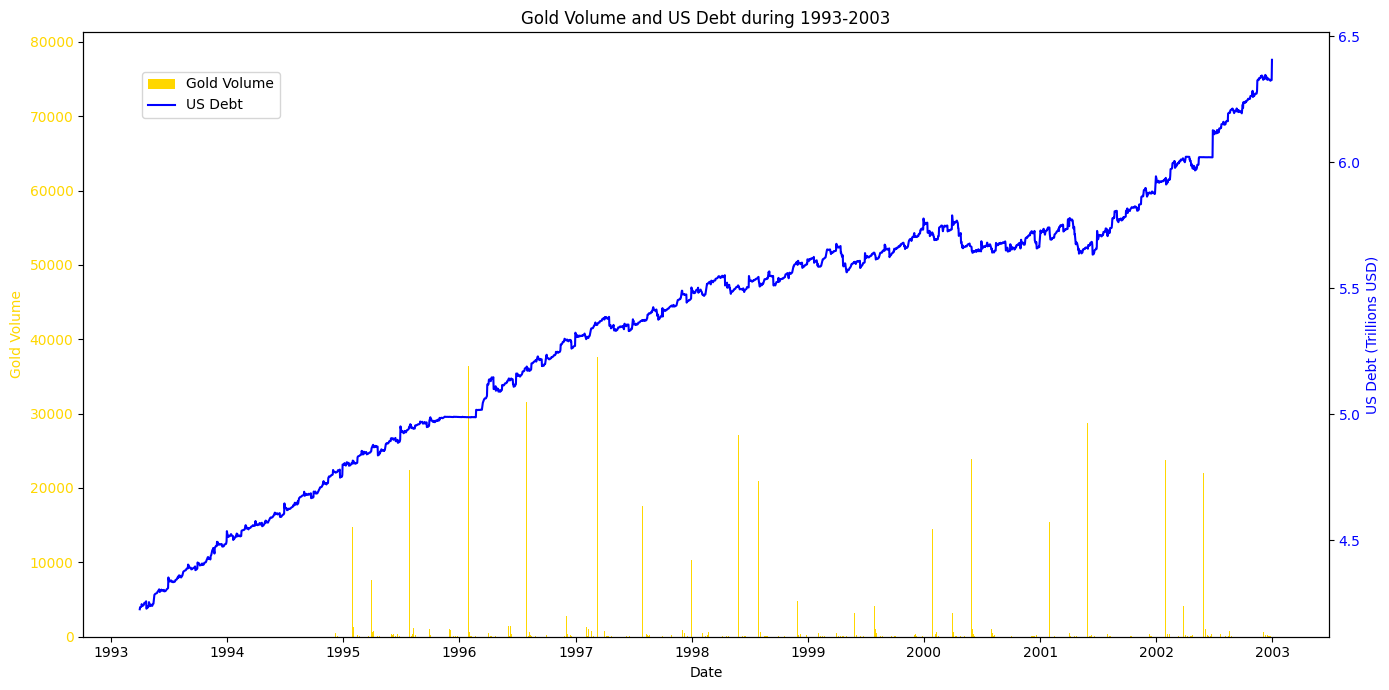

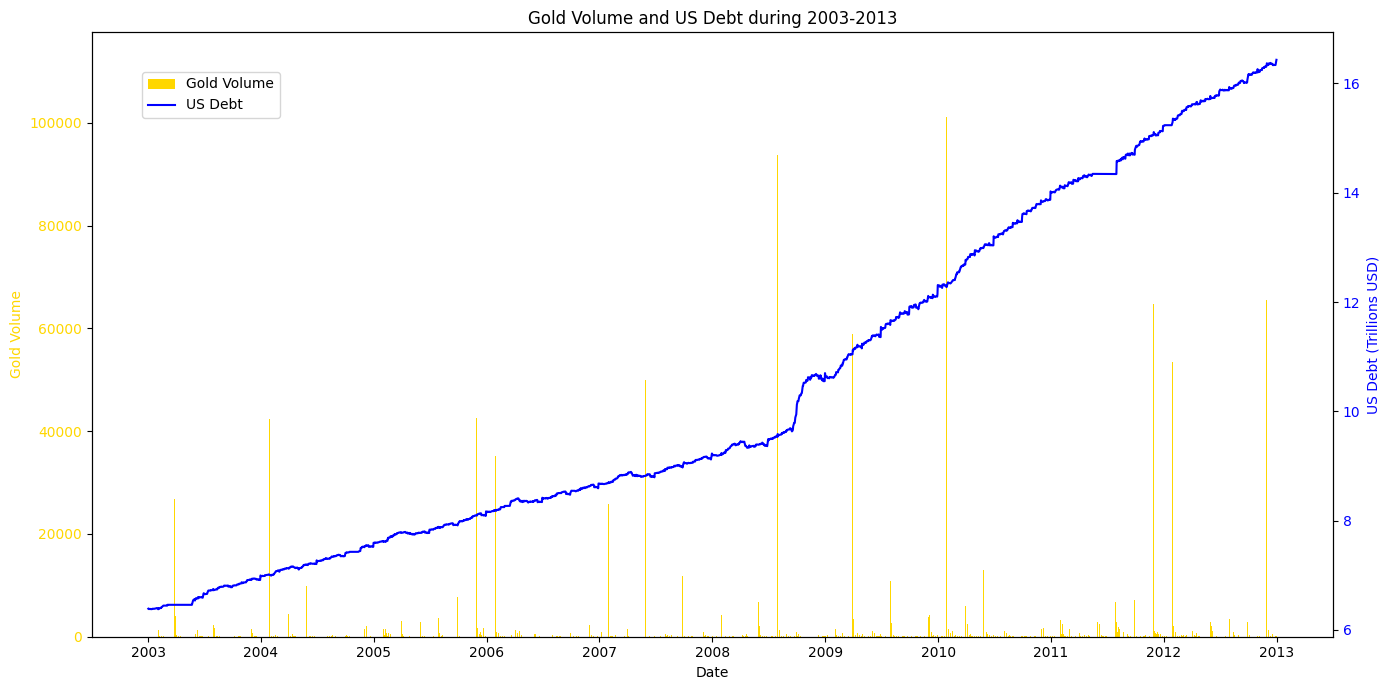

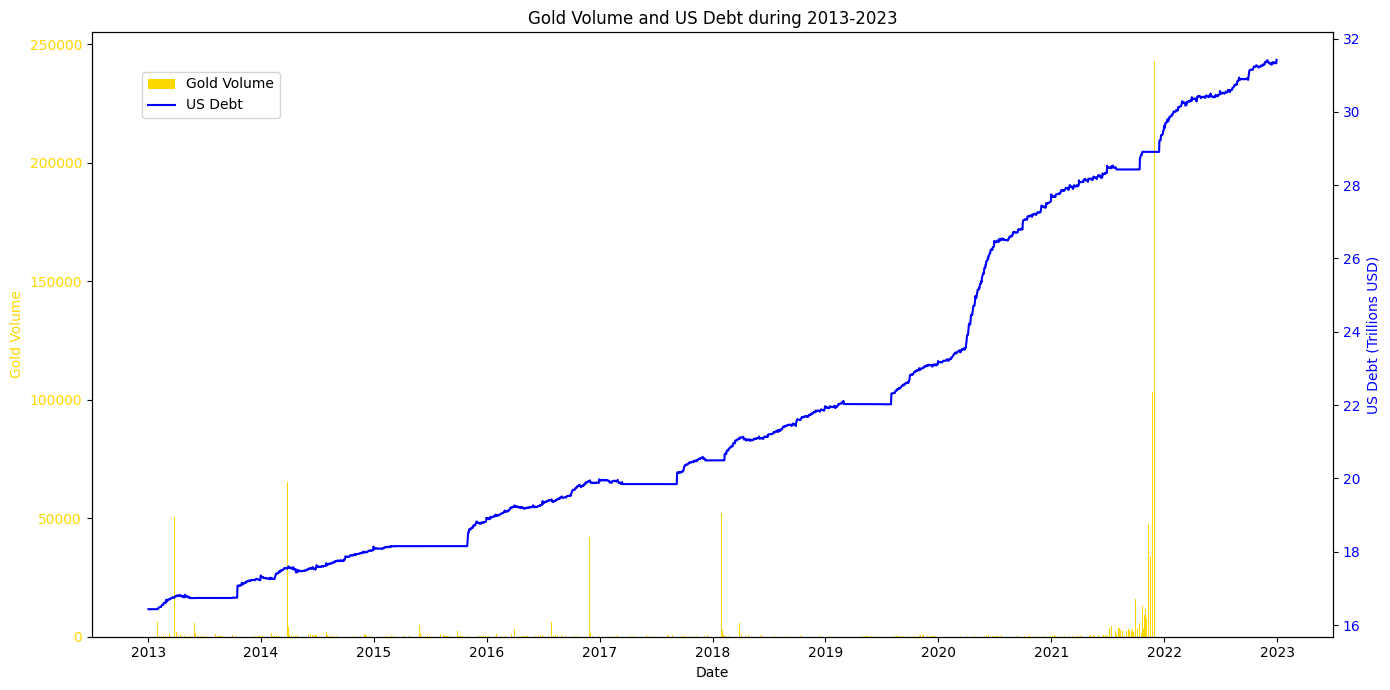

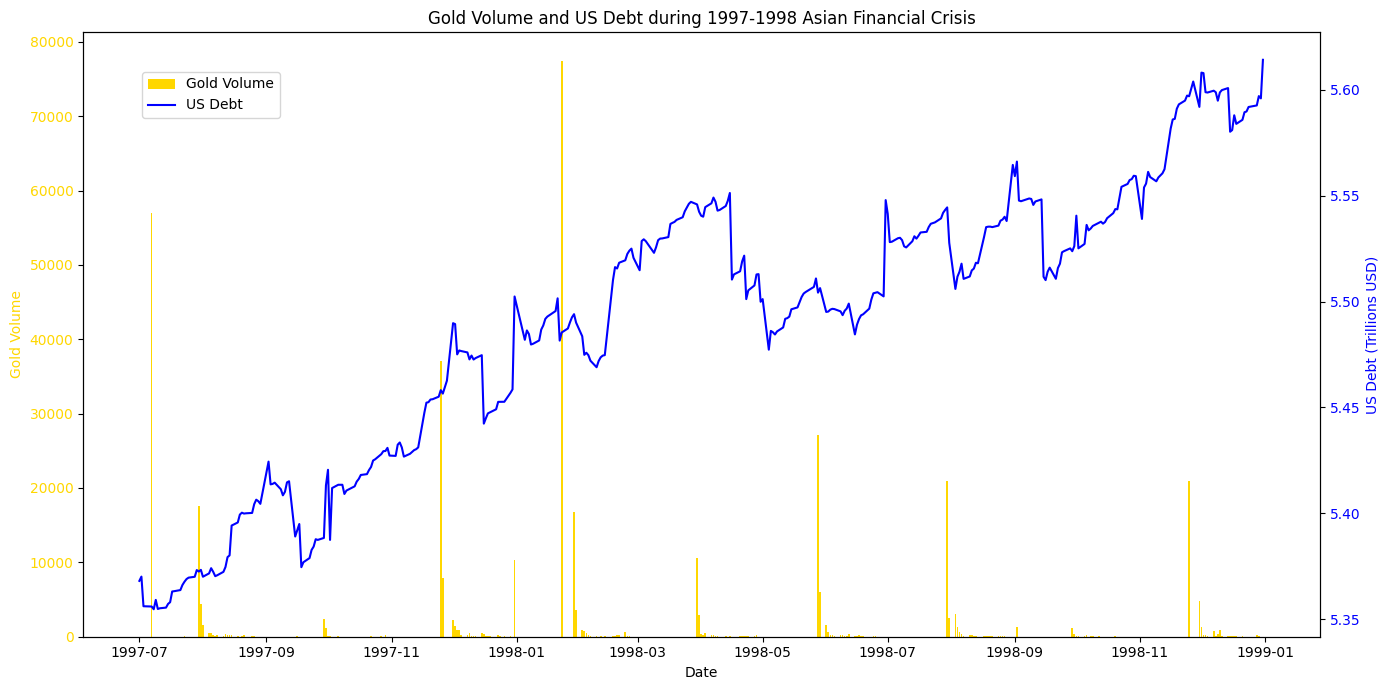

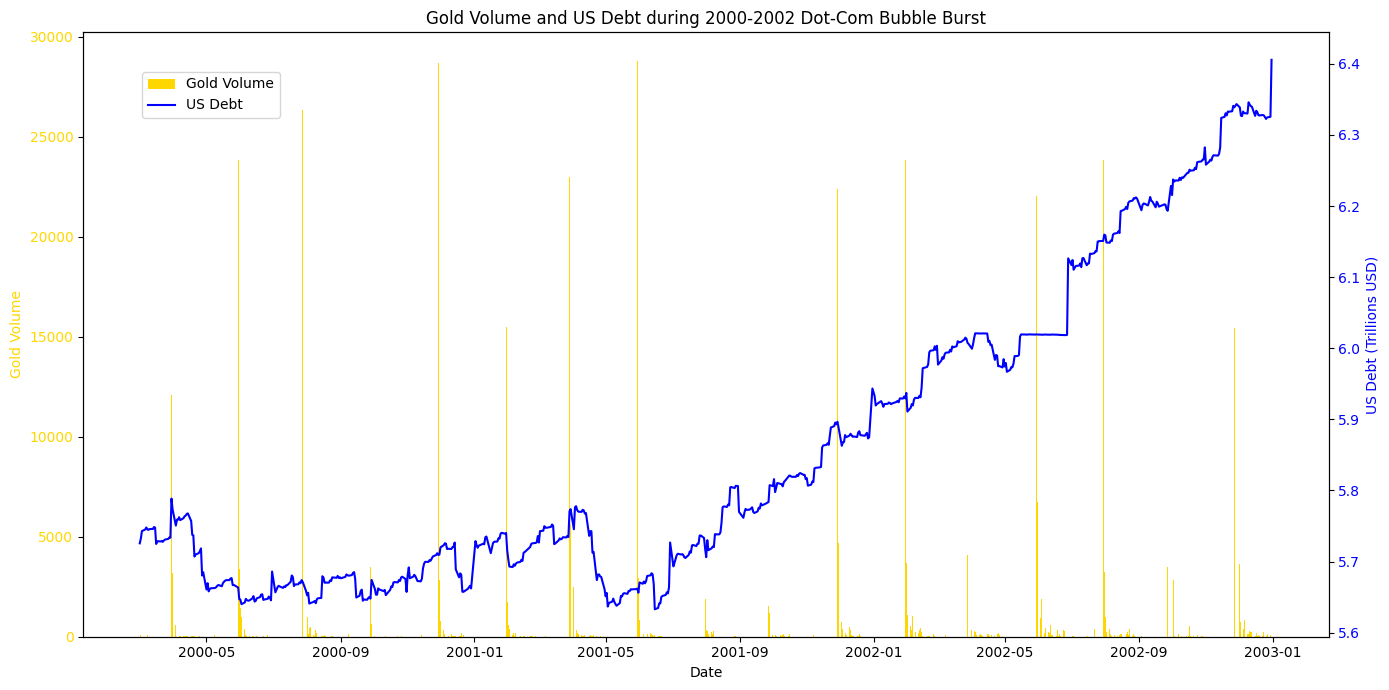

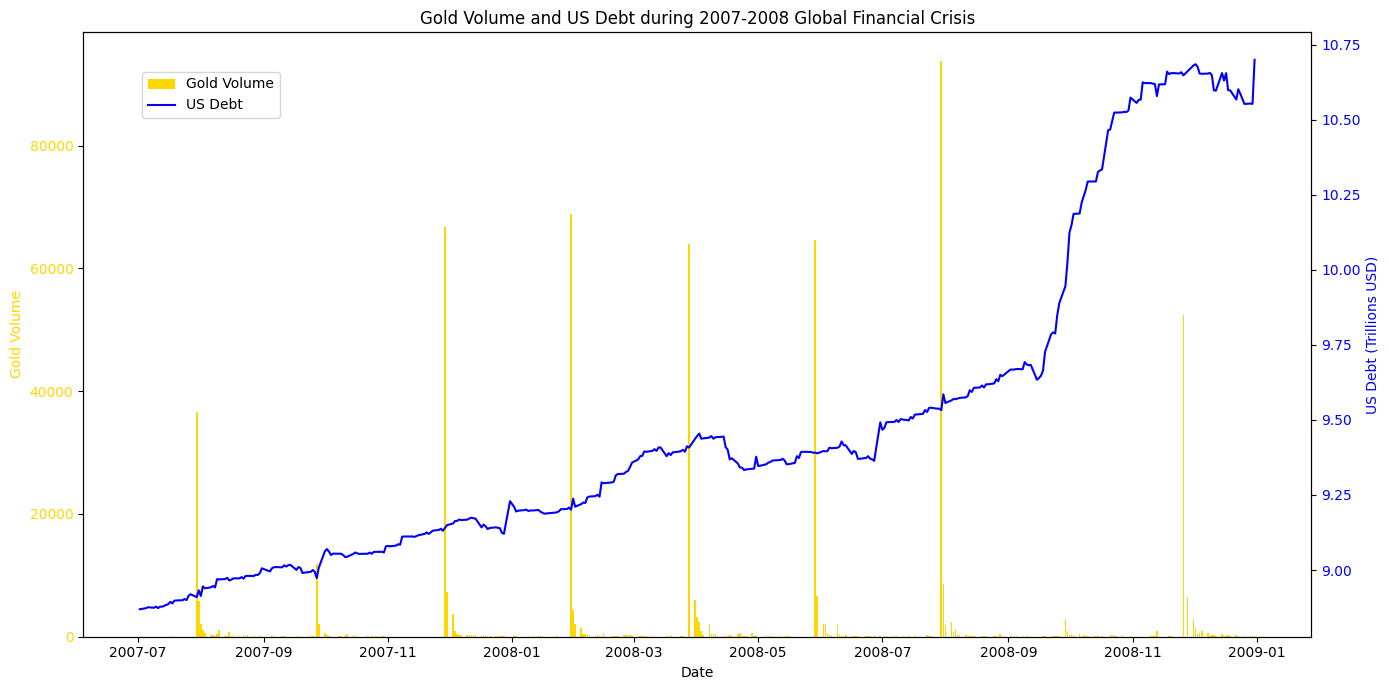

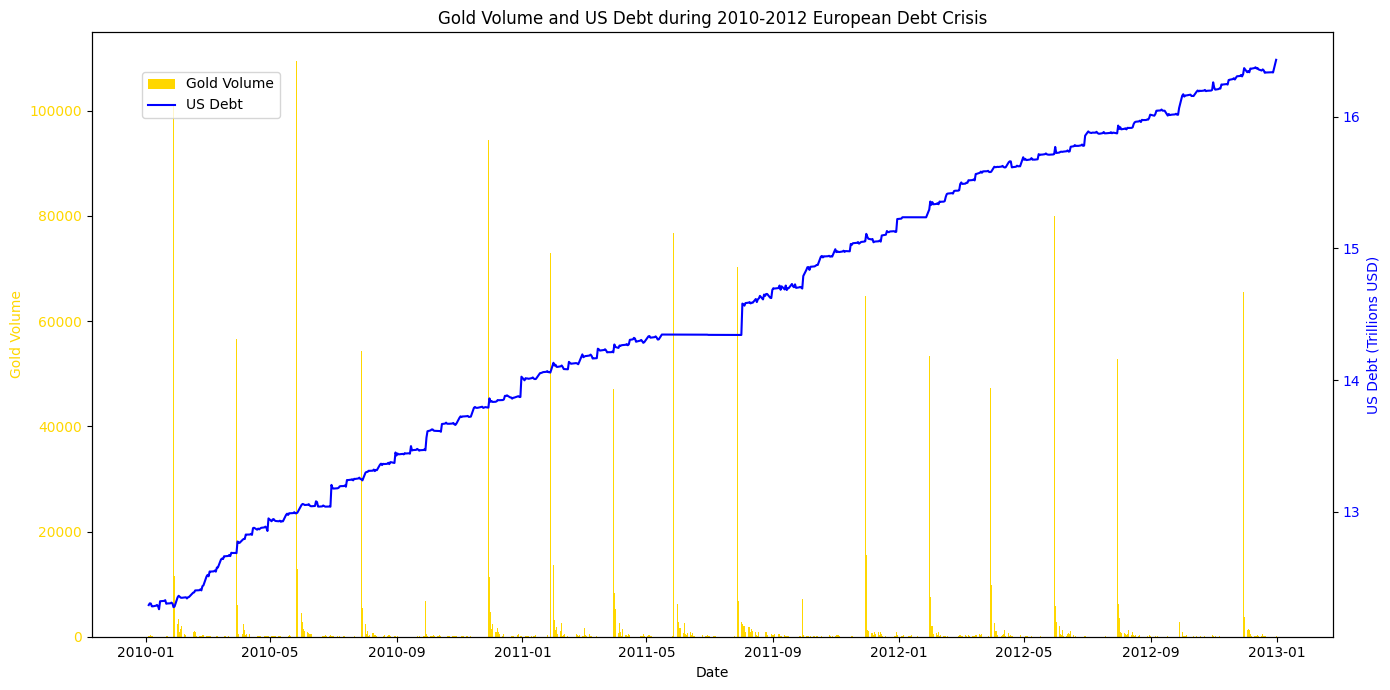

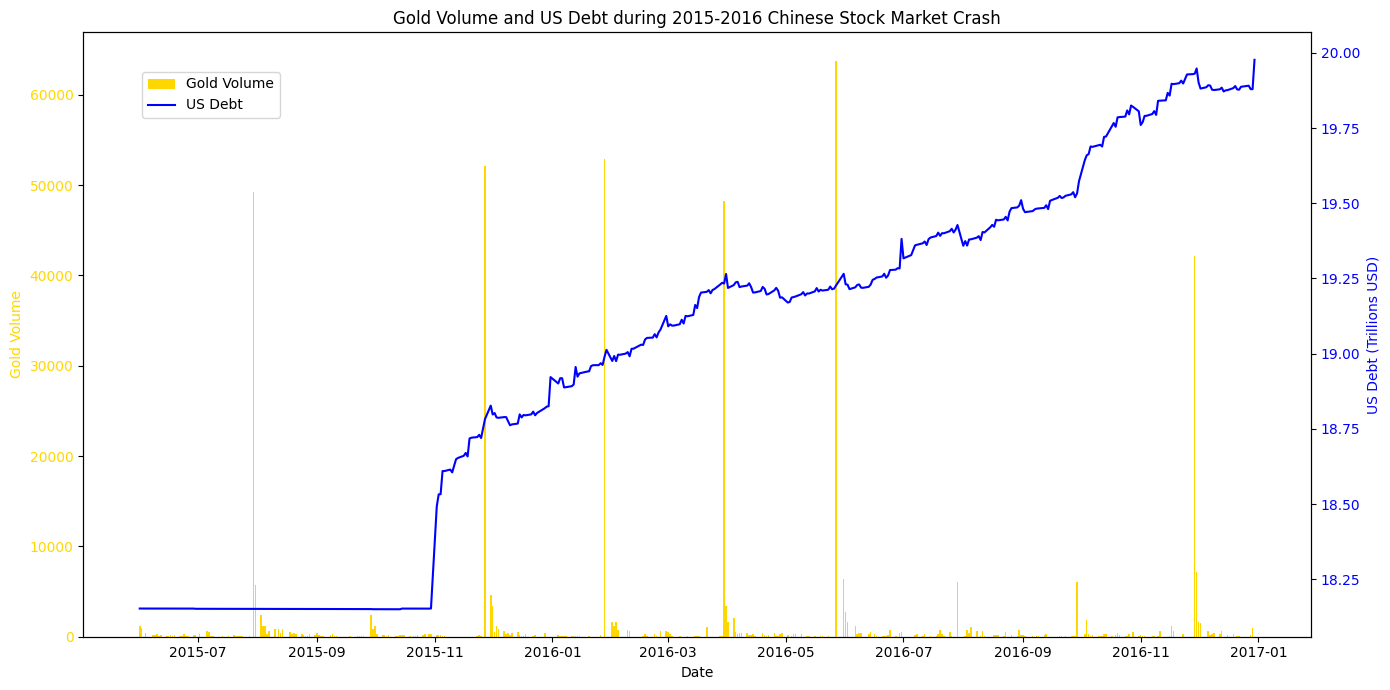

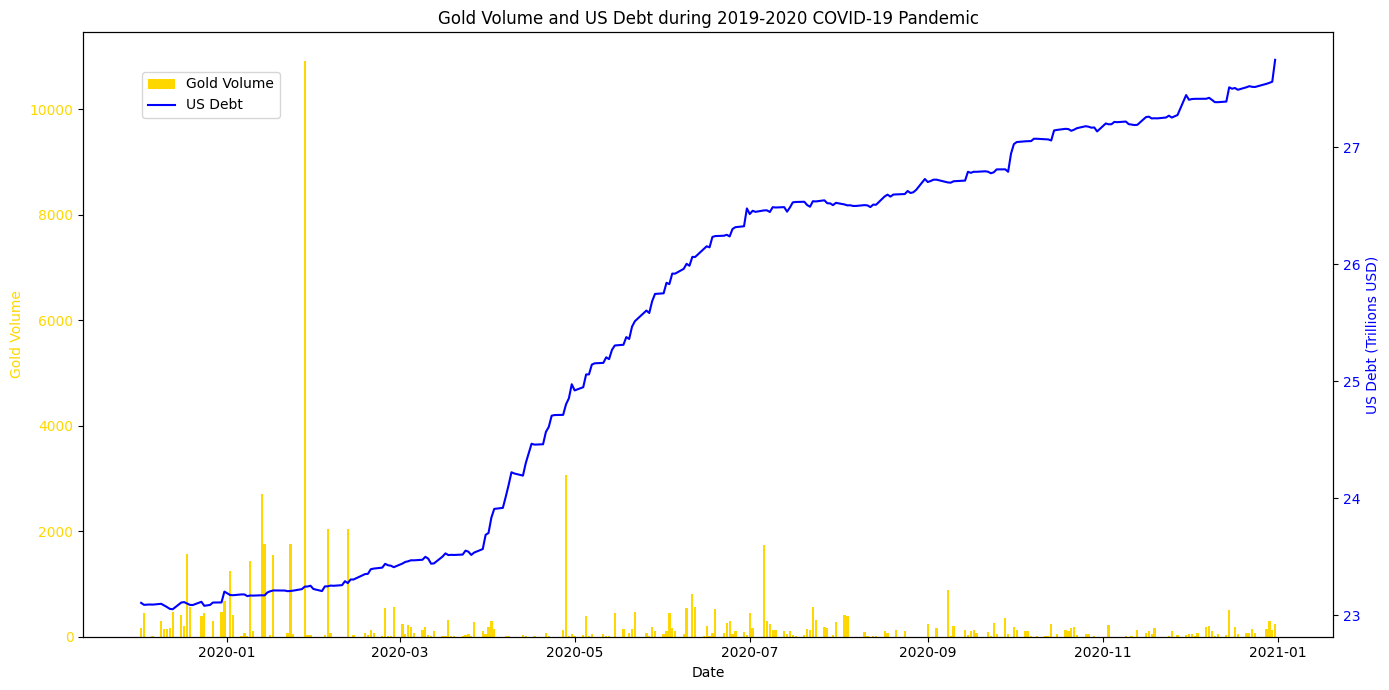

In [18]:
# Make a function that do the bar plot of gold_data_2['Volume'] and line chart of debt_to_penny_df['tot_pub_debt_out_amt'] aside for a given parameter

def plot_aside_2(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.bar(gold_data_2[start_date:end_date].index, gold_data_2[start_date:end_date]['Volume'], color='gold', label='Gold Volume')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Volume', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_to_penny_df[start_date:end_date].index, debt_to_penny_df[start_date:end_date]['tot_pub_debt_out_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Gold Volume and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

# Example usage

for period_name, (start_date, end_date) in decenal_periods.items():
    plot_aside_2(start_date=start_date, end_date=end_date, crisis_periods=period_name)

for period_name, (start_date, end_date) in crisis_periods.items():
    plot_aside_2(start_date=start_date, end_date=end_date, crisis_periods=period_name)

### Histogram of retruns for gold and Debt

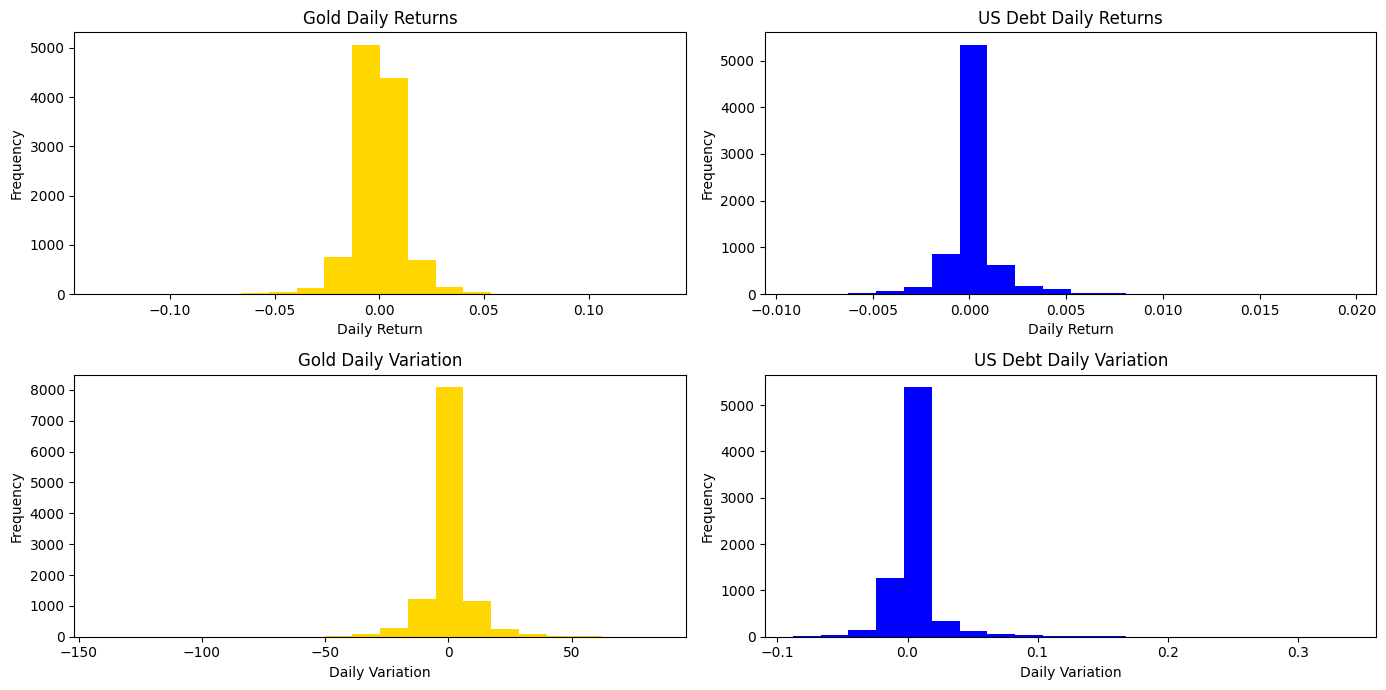

In [ ]:
# Histogram of daily returns for gold and debt

fig, ax = plt.subplots(2, 2, figsize=(14, 7))

gold_data_usd['daily_return'].plot.hist(bins=20, ax=ax[0, 0], color='gold')
ax[0, 0].set_title('Gold Daily Returns')
ax[0, 0].set_xlabel('Daily Return')
ax[0, 0].set_ylabel('Frequency')

debt_to_penny_df['daily_return'].plot.hist(bins=20, ax=ax[0, 1], color='blue')
ax[0, 1].set_title('US Debt Daily Returns')
ax[0, 1].set_xlabel('Daily Return')
ax[0, 1].set_ylabel('Frequency')

gold_data_usd['daily_variation'].plot.hist(bins=20, ax=ax[1, 0], color='gold')
ax[1, 0].set_title('Gold Daily Variation')
ax[1, 0].set_xlabel('Daily Variation')
ax[1, 0].set_ylabel('Frequency')

debt_to_penny_df['daily_variation'].plot.hist(bins=20, ax=ax[1, 1], color='blue')
ax[1, 1].set_title('US Debt Daily Variation')
ax[1, 1].set_xlabel('Daily Variation')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



### Heatmap of US Debt Variation and Gold variation

C:\Users\Bilal\AppData\Local\Temp\ipykernel_5024\3973635762.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  debt_variation_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Variation')


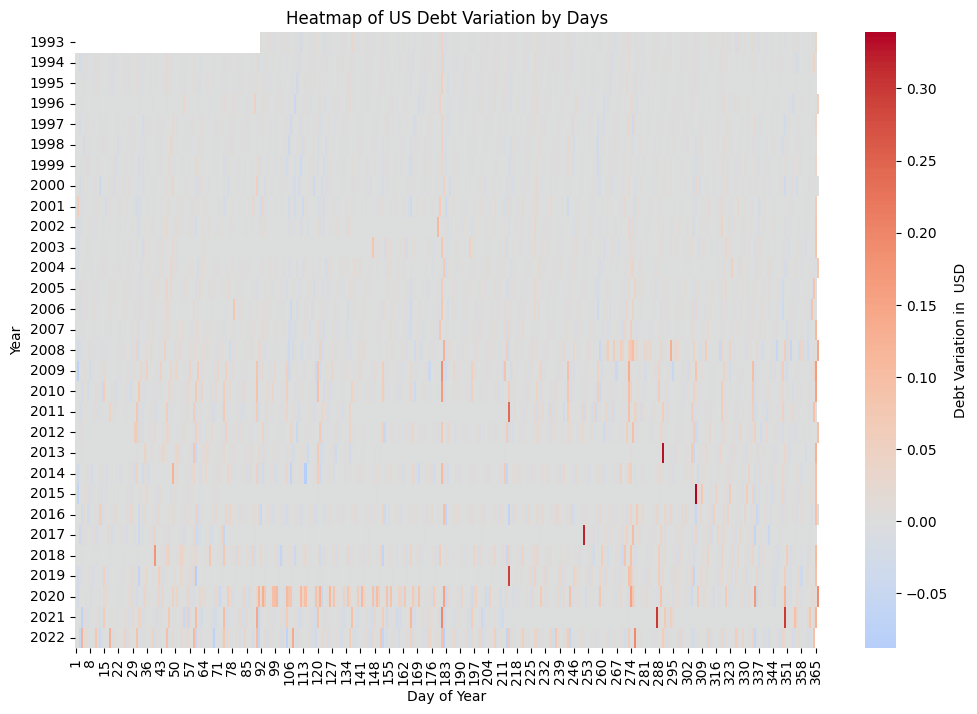

C:\Users\Bilal\AppData\Local\Temp\ipykernel_5024\3973635762.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  gold_variation_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Variation')


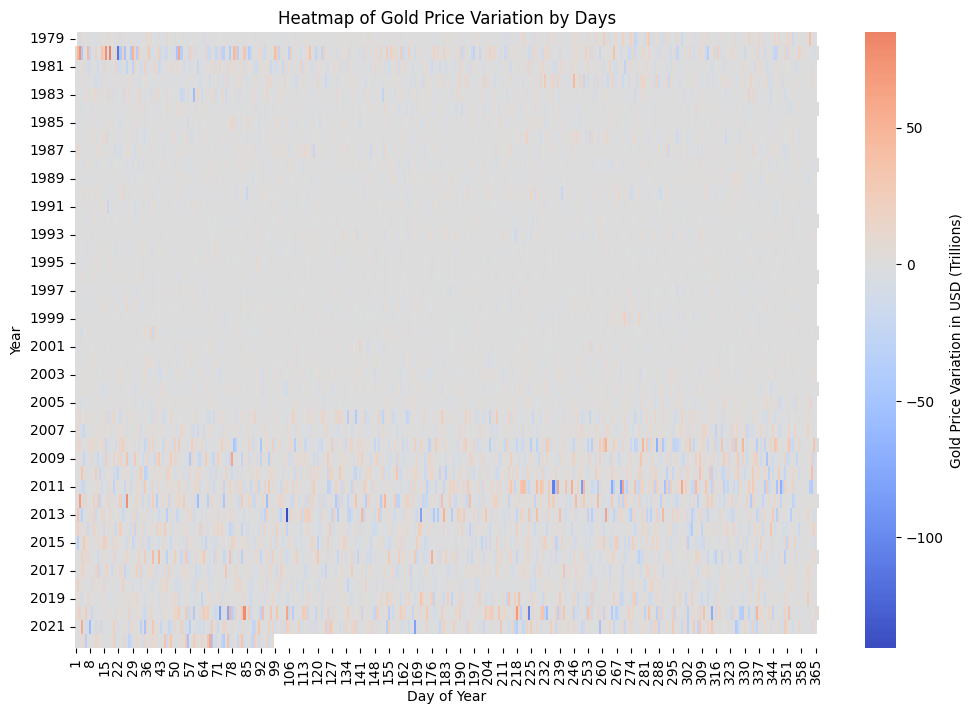

C:\Users\Bilal\AppData\Local\Temp\ipykernel_5024\3973635762.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  gold_volume_pivot = gold_daily_2.pivot('Year', 'DayOfYear', 'Gold_Volume')


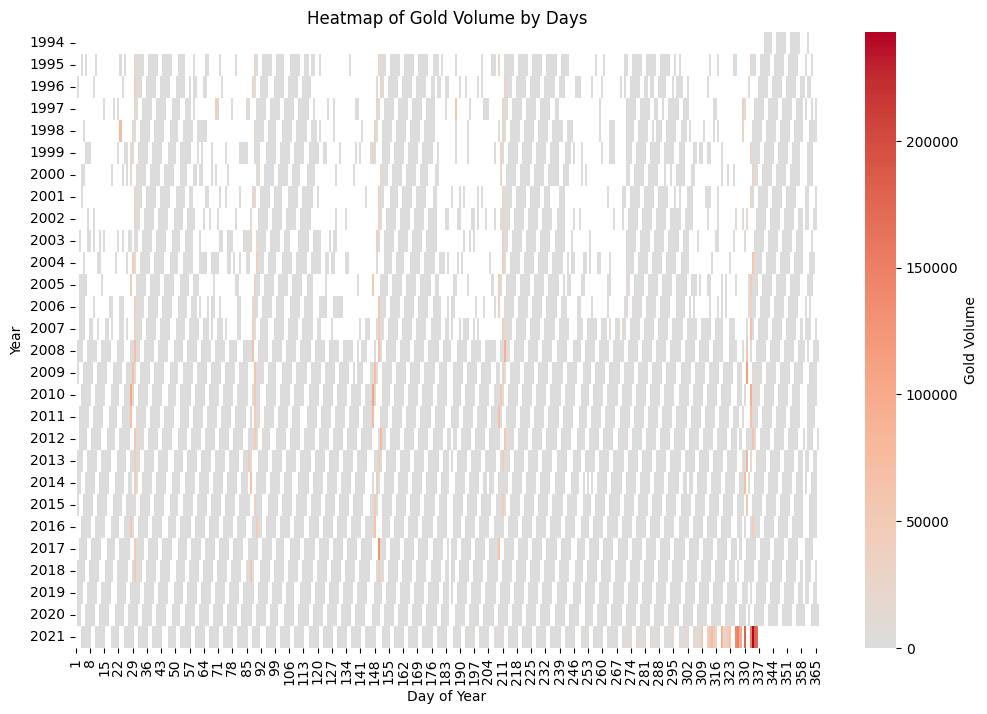

In [22]:
import seaborn as sns

# Resample the data to daily frequency and fill missing values
debt_daily = debt_to_penny_df.resample('D').ffill()

# Create a pivot table with years as rows and days of the year as columns
debt_daily['Year'] = debt_daily.index.year
debt_daily['DayOfYear'] = debt_daily.index.dayofyear
# Calculate the daily variation in debt
debt_daily['Debt_Variation'] = debt_daily['tot_pub_debt_out_amt'].diff()

# Create a pivot table with years as rows and days of the year as columns for debt variation
debt_variation_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Variation')

# Plot the heatmap for debt variation
plt.figure(figsize=(12, 8))
sns.heatmap(debt_variation_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Debt Variation in  USD'})
plt.title('Heatmap of US Debt Variation by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Resample the gold data to daily frequency and fill missing values
gold_daily = gold_data_usd.resample('D').ffill()

# Create a pivot table with years as rows and days of the year as columns
gold_daily['Year'] = gold_daily.index.year
gold_daily['DayOfYear'] = gold_daily.index.dayofyear
# Calculate the daily variation in gold price
gold_daily['Gold_Variation'] = gold_daily['usd_price'].diff()

# Create a pivot table with years as rows and days of the year as columns for gold price variation
gold_variation_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Variation')

# Plot the heatmap for gold price variation
plt.figure(figsize=(12, 8))
sns.heatmap(gold_variation_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Gold Price Variation in USD (Trillions)'})
plt.title('Heatmap of Gold Price Variation by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Plot the heatmap for gold volume 
gold_daily_2 = gold_data_2.resample('D').ffill()
gold_daily_2['Year'] = gold_daily_2.index.year
gold_daily_2['DayOfYear'] = gold_daily_2.index.dayofyear
gold_daily_2['Gold_Volume'] = gold_data_2['Volume']

gold_volume_pivot = gold_daily_2.pivot('Year', 'DayOfYear', 'Gold_Volume')

plt.figure(figsize=(12, 8))
sns.heatmap(gold_volume_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Gold Volume'})
plt.title('Heatmap of Gold Volume by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()


### Heatmap of US Daily Return and Gold Daily Return

C:\Users\Bilal\AppData\Local\Temp\ipykernel_31776\788313781.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  gold_return_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Return')


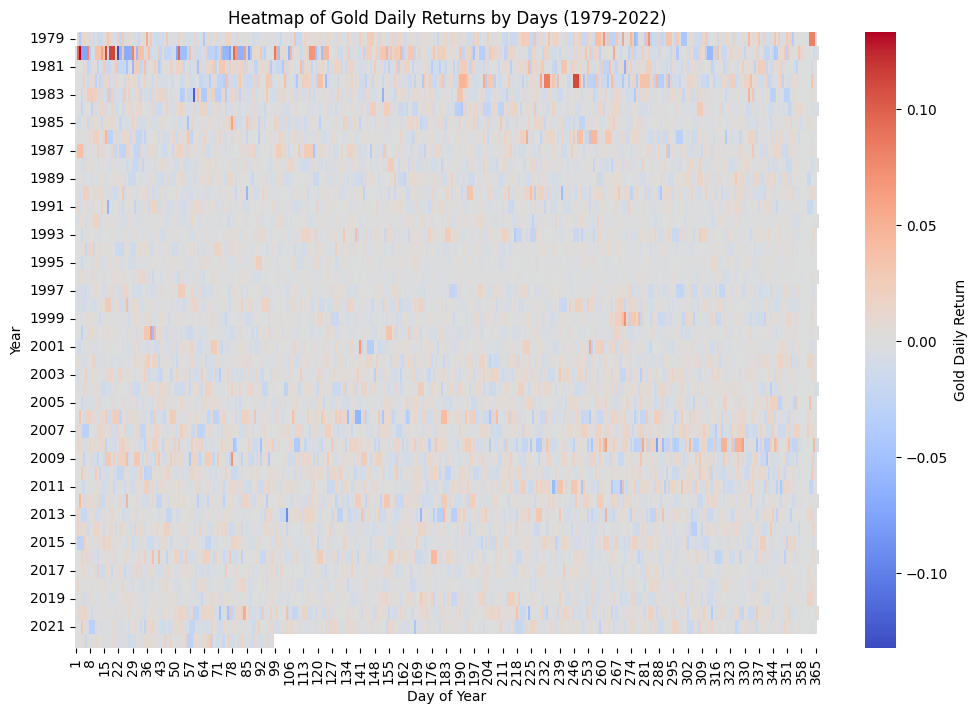

C:\Users\Bilal\AppData\Local\Temp\ipykernel_31776\788313781.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  debt_return_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Return')


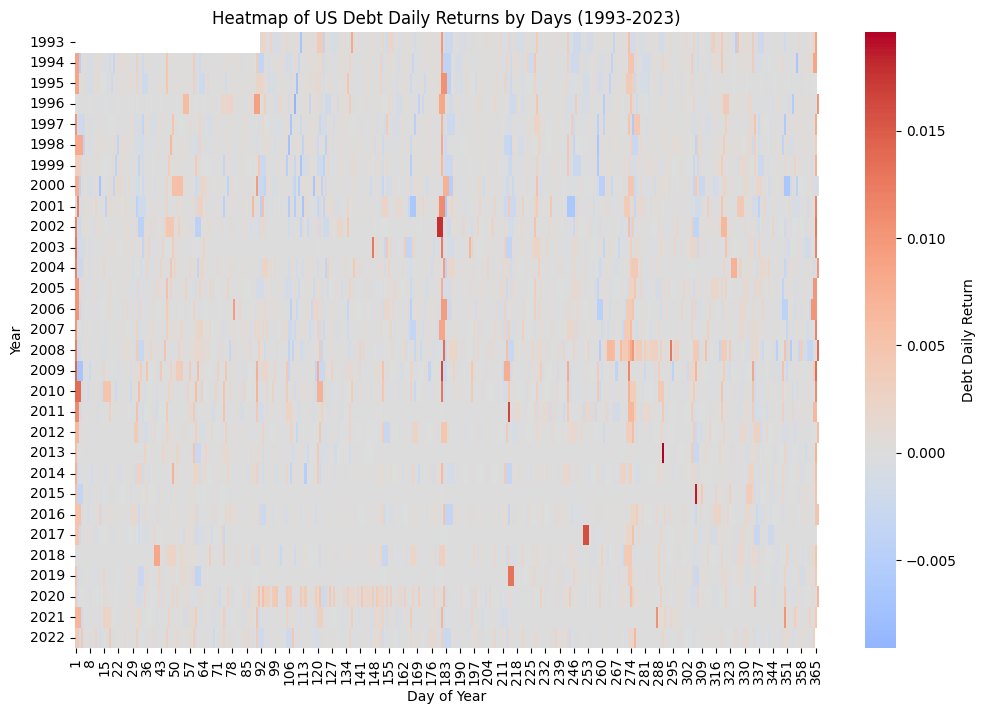

In [ ]:
# Heatmap of Gold daily returns by year
gold_daily['Gold_Return'] = gold_daily['daily_return']
gold_return_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Return')

plt.figure(figsize=(12, 8))
sns.heatmap(gold_return_pivot, cmap='coolwarm', center=0, cbar_kws={'label': 'Gold Daily Return'})
plt.title('Heatmap of Gold Daily Returns by Days (1979-2022)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Heatmap of Debt daily returns by year
debt_daily['Debt_Return'] = debt_daily['daily_return']
debt_return_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Return')

plt.figure(figsize=(12, 8))
sns.heatmap(debt_return_pivot, cmap='coolwarm', center=0, cbar_kws={'label': 'Debt Daily Return'})
plt.title('Heatmap of US Debt Daily Returns by Days (1993-2023)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

## Statistical Analysis

### Compute correlations between gold prices and US debt

In [ ]:
def correlation_analysis(periods):
    # Create a DataFrame to store the correlation values
    columns = pd.MultiIndex.from_product([["gold_vs_debt"],["correlation","correlation_daily_return"]])
    correlations = pd.DataFrame(data=[], index=periods.keys(), columns=columns)

    # Calculate and print the correlation for each period
    for period, (start_date, end_date) in periods.items():
        gold_period = gold_data_usd[start_date:end_date]
        debt_period = debt_to_penny_df[start_date:end_date]
        
        # Merge the dataframes on the date index
        merged_data = pd.merge(gold_period, debt_period, left_index=True, right_index=True)
        
        # Calculate the correlation
        correlation = merged_data['usd_price'].corr(merged_data['tot_pub_debt_out_amt'])
        correlations.loc[period,("gold_vs_debt","correlation")] = correlation
        
        # Calculate the correlation of daily returns
        correlation_dr = merged_data['daily_return_x'].corr(merged_data['daily_return_y'])
        correlations.loc[period,("gold_vs_debt","correlation_daily_return")] = correlation_dr
        
    return correlations

def find_best_correlated_periods(first_date, last_date):
    # create a dictionary to store the periods
    periods = {}

    # Look for the best correlation within first and last_date
    for i in range(1, 11):
        start_date = pd.to_datetime(first_date)
        end_date = start_date + pd.DateOffset(years=i)
        if end_date > pd.to_datetime(last_date):
            break
        periods[f'Period {i}'] = (start_date, end_date)

    # Calculate the correlation for each period
    correlations = correlation_analysis(periods)
    # Find the period with the highest correlation
    best_period = correlations.idxmax().values[0][0]

    return periods[best_period],correlations




gold_vs_debt                         
           correlation correlation_daily_return
1993-2000    -0.812198                 0.004106
2000-2008     0.943344                -0.000451
2008-2011     0.912345                 0.000132
2011-2019    -0.499183                 0.030921

### Merging gold and debt data in one dataframe

In [ ]:
full_data = gold_data_usd.merge(debt_to_penny_df, how="outer", left_index=True, right_index=True)
# rename columns and drop NaN values
full_data = full_data.rename(columns={"tot_pub_debt_out_amt": "debt_amt", "usd_price" : "gold_price", "daily_return_x": "gold_daily_return", "daily_return_y": "debt_daily_return", "daily_variation_x": "gold_daily_variation", "daily_variation_y": "debt_daily_variation"}).dropna()
full_data.head()

,gold_price,gold_daily_return,gold_daily_variation,volatility_7d,volatility_28d,volatility_90d,volatility_365d,debt_amt,debt_daily_return,debt_daily_variation
1993-04-02,340.10,0.011149,3.75,0.045521,0.016270,0.007961,0.005184,4.233931,0.001907,0.008057
1993-04-05,339.25,-0.002499,-0.85,0.048514,0.016458,0.007982,0.005177,4.234896,0.000228,0.000965
1993-04-06,338.40,-0.002506,-0.85,0.050365,0.016583,0.007998,0.005178,4.235831,0.000221,0.000935
1993-04-07,336.75,-0.004876,-1.65,0.052345,0.016358,0.008044,0.005177,4.246168,0.002440,0.010337
1993-04-08,337.50,0.002227,0.75,0.048870,0.016335,0.008053,0.005178,4.242020,-0.000977,-0.004148


### Test de Causalité de Granger

Le test de causalité de Granger est une méthode statistique utilisée pour déterminer si une série temporelle peut prédire une autre série temporelle. Contrairement à une simple analyse de corrélation, qui mesure seulement la force et la direction de la relation linéaire entre deux variables, le test de Granger examine la capacité d'une variable à fournir des informations sur les valeurs futures d'une autre variable.

#### Pertinence par rapport à une analyse de corrélation

1. **Directionnalité** : La corrélation ne donne aucune information sur la direction de la relation. Le test de Granger peut indiquer si X cause Y ou si Y cause X.
2. **Temporalité** : La corrélation est une mesure instantanée et ne prend pas en compte les décalages temporels. Le test de Granger intègre les décalages temporels pour évaluer la relation causale.
3. **Prédiction** : La corrélation ne peut pas être utilisée pour la prédiction, alors que le test de Granger est spécifiquement conçu pour évaluer la capacité prédictive d'une série temporelle sur une autre.

Voici un exemple de mise en œuvre du test de causalité de Granger en Python avec la bibliothèque `statsmodels` :

```python
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Exemple de données
data = {'X': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'Y': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
df = pd.DataFrame(data)

# Test de causalité de Granger
result = grangercausalitytests(df[['Y', 'X']], maxlag=2)

# Affichage des résultats
for key in result:
    print(f"Lag {key}:")
    for test in result[key][0]:
        print(f"{test}: {result[key][0][test]}")

Statistique ADF: 0.4622454098248467
Valeur p: 0.9836792586204506
Valeurs critiques: {'1%': -3.4312530395833467, '5%': -2.861939073060013, '10%': -2.566982422386691}
Statistique ADF: 4.828381781456944
Valeur p: 1.0
Valeurs critiques: {'1%': -3.431252416490739, '5%': -2.8619387977434867, '10%': -2.566982275831387}


C:\Users\Bilal\AppData\Local\Temp\ipykernel_6712\4040906205.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gold_price'] = data['gold_price'].diff().dropna()
C:\Users\Bilal\AppData\Local\Temp\ipykernel_6712\4040906205.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['debt_amt'] = data['debt_amt'].diff().dropna()


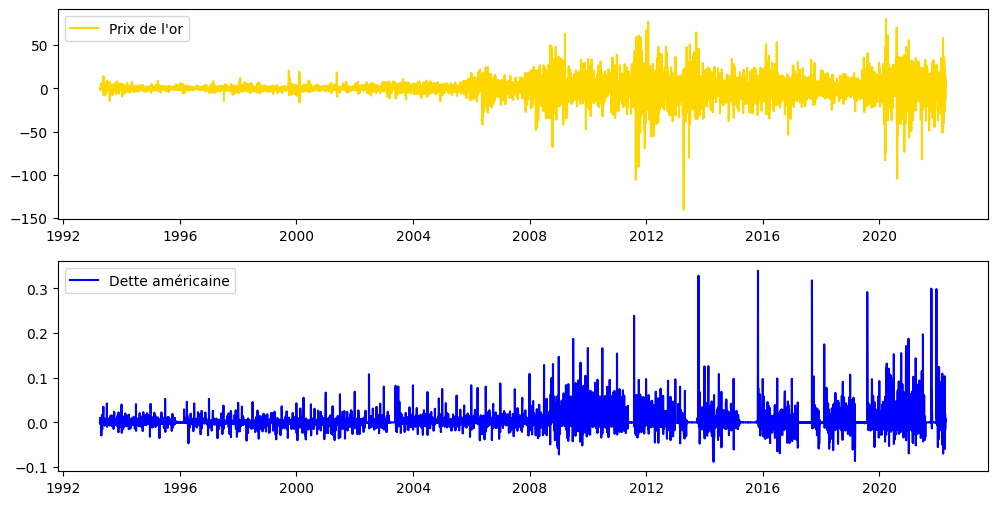

Statistique ADF: -15.846570752127866
Valeur p: 9.556242512213274e-29
Valeurs critiques: {'1%': -3.4312530395833467, '5%': -2.861939073060013, '10%': -2.566982422386691}
Statistique ADF: -9.471993868130998
Valeur p: 4.0827973233845095e-16
Valeurs critiques: {'1%': -3.4312525410404624, '5%': -2.8619388527763974, '10%': -2.5669823051262677}


C:\Users\Bilal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.981      -2.979     0.05072      -2.981
1       -2.985      -2.980     0.05052      -2.983
2       -2.986      -2.977     0.05047      -2.983
3       -2.987      -2.974     0.05042      -2.983
4       -2.989      -2.971     0.05036      -2.983
5       -3.006      -2.985     0.04948      -2.999
6       -3.007      -2.983     0.04942      -2.999
7       -3.007      -2.979     0.04942      -2.998
8       -3.009      -2.976     0.04936      -2.997
9       -3.012      -2.976     0.04917      -3.000
10      -3.028      -2.988     0.04842      -3.014
11      -3.044     -3.000*     0.04765      -3.029
12      -3.046      -2.998     0.04757     -3.029*
13      -3.045      -2.993     0.04761      -3.027
14      -3.044      -2.989     0.04763      -3.025
15      -3.044      -2.985     0.04763      -3.024
16      -3.045      -2.982     

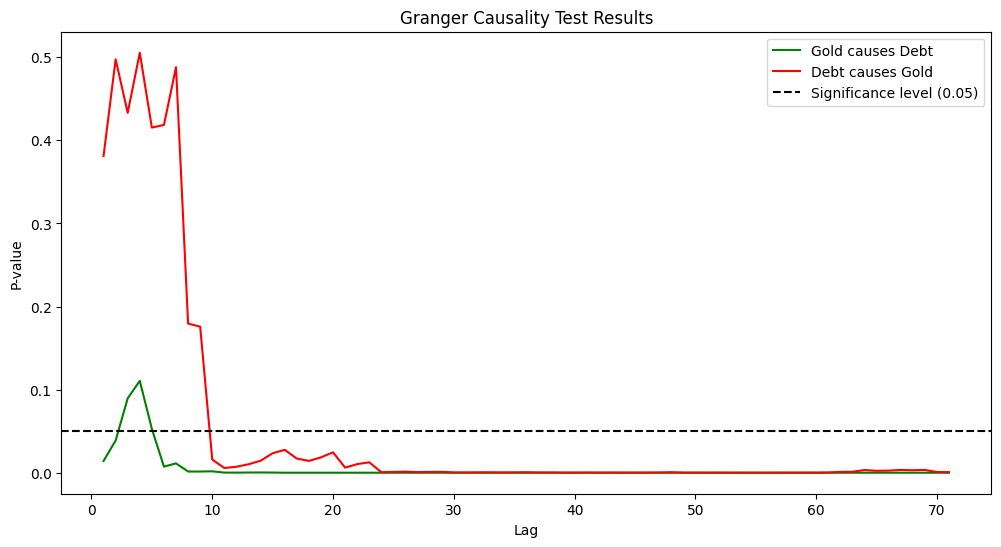

le maxlag optimal est pour les données daily est 71 jours soit 2 mois environ


In [ ]:

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR

# Charger les données
data = full_data[['gold_price', 'debt_amt']]

# Vérifier la stationnarité des séries temporelles
def check_stationarity(series):
    result = adfuller(series)
    print(f'Statistique ADF: {result[0]}')
    print(f'Valeur p: {result[1]}')
    print(f'Valeurs critiques: {result[4]}')
    return result[1] < 0.05  # Retourne True si la série est stationnaire

# Appliquer le test ADF sur les deux séries
is_gold_price_stationary = check_stationarity(data['gold_price'])
is_us_debt_stationary = check_stationarity(data['debt_amt'])

# Différencier les séries si elles ne sont pas stationnaires
if not is_gold_price_stationary:
    data['gold_price'] = data['gold_price'].diff().dropna()
if not is_us_debt_stationary:
    data['debt_amt'] = data['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data = data.dropna()

# Visualiser les séries temporelles après nettoyage
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data['gold_price'], label='Prix de l\'or', color='gold')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data['debt_amt'], label='Dette américaine', color='blue')
plt.legend()
plt.show()

check_stationarity(data['gold_price'])
check_stationarity(data['debt_amt'])

# Effectuer le test de causalité de Granger
max_lag = 90  # On teste jusqu'à 90 jour de lags (environ 3 mois)
model = VAR(data[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
print(lag_order.summary())

# Utiliser le nombre optimal de lags pour le test de Granger
optimal_lag = lag_order.aic

result_gold_cause_debt = grangercausalitytests(data[['gold_price', 'debt_amt']], optimal_lag, verbose=False) # Test de causalité de l'or sur la dette
result_debt_cause_gold = grangercausalitytests(data[['debt_amt', 'gold_price']], optimal_lag, verbose=False) # Test de causalité de la dette sur l'or

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results')
plt.legend()
plt.show()

print(f'le maxlag optimal est pour les données daily est {optimal_lag} jours soit {optimal_lag//30} mois environ')

### Problème des P-valeurs qui Tendent vers 0

Lorsque les p-valeurs descendent à 0 pour des lags élevés dans un test de causalité de Granger, cela peut être dû à plusieurs facteurs :

1. **Surajustement (Overfitting)** : Avec un nombre élevé de lags, le modèle peut commencer à surajuster les données, capturant non seulement les relations réelles mais aussi le bruit aléatoire. Cela peut entraîner des p-valeurs artificiellement faibles, indiquant une causalité apparente qui n'est pas réellement présente.

2. **Autocorrélation** : Les séries temporelles peuvent avoir une forte autocorrélation, ce qui signifie que les valeurs passées influencent fortement les valeurs futures. Lorsque le nombre de lags est élevé, le modèle peut capturer cette autocorrélation, ce qui peut entraîner des p-valeurs faibles.

3. **Dépendance Spurious** : Avec un grand nombre de lags, il est possible que des relations spurious (fausses) soient détectées. Cela peut se produire lorsque le modèle trouve des corrélations qui ne sont pas réellement causales mais qui apparaissent significatives en raison du grand nombre de paramètres estimés.

4. **Problèmes de Stationnarité** : Si les séries temporelles ne sont pas correctement stationnarisées, cela peut entraîner des résultats trompeurs. Les séries non stationnaires peuvent montrer des tendances ou des cycles qui peuvent être mal interprétés comme des relations causales.

5. **Taille de l'Échantillon** : Avec un grand nombre de lags, le nombre de paramètres à estimer augmente, ce qui peut réduire la puissance statistique du test, surtout si la taille de l'échantillon est limitée. Cela peut également conduire à des p-valeurs faibles de manière artificielle.

### Proposition : Agrégation des Données

Pour atténuer ces problèmes, une solution consiste à agrégater les données à une fréquence plus faible, comme hebdomadaire (weekly) ou mensuelle (monthly). L'agrégation des données peut aider à :

- **Réduire le Bruit** : En lissant les fluctuations quotidiennes, l'agrégation peut réduire le bruit et rendre les tendances sous-jacentes plus visibles.
- **Simplifier le Modèle** : Avec des données agrégées, le nombre de lags nécessaires pour capturer les relations temporelles peut être réduit, diminuant ainsi le risque de surajustement.
- **Améliorer la Stationnarité** : Les données agrégées peuvent être plus stationnaires, facilitant l'interprétation des résultats du test de Granger.


Statistique ADF: 0.3437598765411624
Valeur p: 0.9792654547260405
Valeurs critiques: {'1%': -3.4347375276423335, '5%': -2.8634778123668374, '10%': -2.5678016687520104}
Statistique ADF: 4.4778302980415825
Valeur p: 1.0
Valeurs critiques: {'1%': -3.434743423170358, '5%': -2.8634804142964025, '10%': -2.567803054306163}


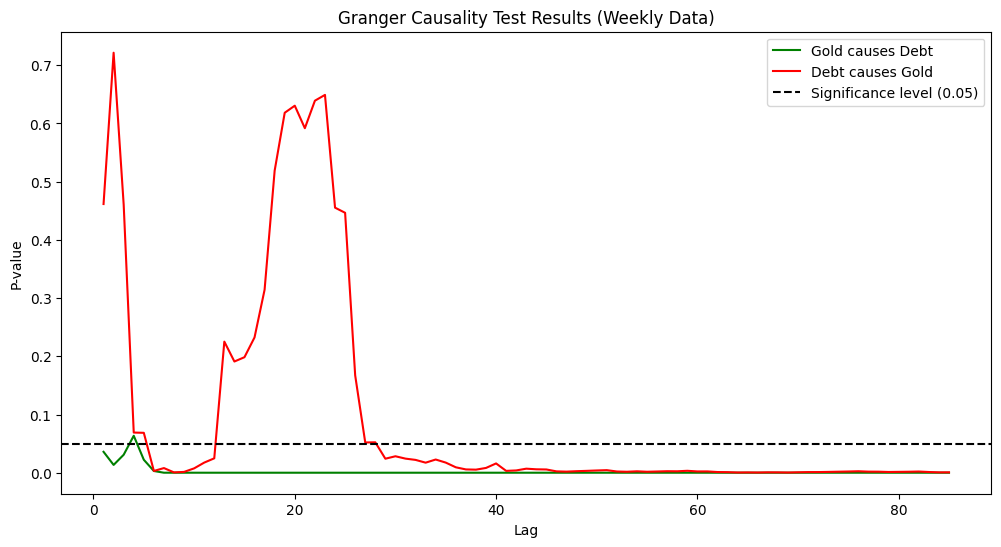

le maxlag optimal est pour les donnée hebdomadaire est 85 soit environ 21 mois
la p-value minimale pour la causalité de l'or sur la dette est 1.318564031541508e-12 obtenue pour un lag de 80 semaines


In [ ]:
# Agrégation hebdomadaire
data_weekly = full_data[['gold_price', 'debt_amt']].resample('W').mean()

# Différencier les séries si elles ne sont pas stationnaires
if not check_stationarity(data_weekly['gold_price']):
    data_weekly['gold_price'] = data_weekly['gold_price'].diff().dropna()
if not check_stationarity(data_weekly['debt_amt']):
    data_weekly['debt_amt'] = data_weekly['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data_weekly = data_weekly.dropna()

# Utiliser le critère d'information pour déterminer le nombre optimal de lags
max_lag = 90 # On teste jusqu'à 90 semaines de lags (environ 2 ans)
model = VAR(data_weekly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Effectuer le test de causalité de Granger avec le nombre optimal de lags
result_gold_cause_debt = grangercausalitytests(data_weekly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_weekly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Weekly Data)')
plt.legend()
plt.show()

print(f'le maxlag optimal est pour les donnée hebdomadaire est {optimal_lag} soit environ {optimal_lag//4} mois')
print(f'la p-value minimale pour la causalité de l\'or sur la dette est {min(p_values_gold_cause_debt)} obtenue pour un lag de {p_values_gold_cause_debt.index(min(p_values_gold_cause_debt))} semaines')

Statistique ADF: 0.2645274515074037
Valeur p: 0.9756571962484314
Valeurs critiques: {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}
Statistique ADF: 4.829950264456022
Valeur p: 1.0
Valeurs critiques: {'1%': -3.4493918438232525, '5%': -2.8699298018856574, '10%': -2.5712397066390458}


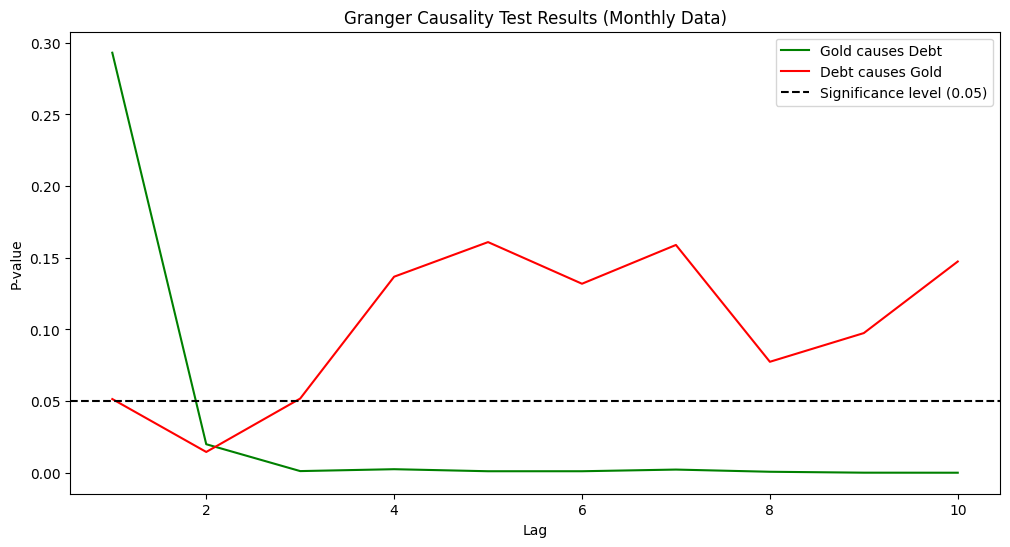

Le lag optimal pour les données mensuelles est 10 mois


In [ ]:
# Agrégation mensuelle

data_monthly = full_data[['gold_price', 'debt_amt']].resample('M').mean()

# Différencier les séries si elles ne sont pas stationnaires
if not check_stationarity(data_monthly['gold_price']):
    data_monthly['gold_price'] = data_monthly['gold_price'].diff().dropna()
if not check_stationarity(data_monthly['debt_amt']):
    data_monthly['debt_amt'] = data_monthly['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data_monthly = data_monthly.dropna()

# Utiliser le critère d'information pour déterminer le nombre optimal de lags

max_lag = 36  # On teste jusqu'à 36 mois de lags (environ 3 ans)
model = VAR(data_monthly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Effectuer le test de causalité de Granger avec le nombre optimal de lags
result_gold_cause_debt = grangercausalitytests(data_monthly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_monthly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Monthly Data)')
plt.legend()
plt.show()

print(f'Le maxlag optimal pour les données mensuelles est {optimal_lag} mois')

### Quelque soit l'échelle de temps, l'hypothèse G->D est plus plausible que D->G (cf. interprétation de la p-value)

---

### NEXT STEP:

Concevoir une stratégie qui utilise les données du marché de l'or pour obtenir des signaux quant à d'éventuels mouvements non anticipés de la dette américaine.

#### Methode :

- **Features** : `gold_price`, `gold_volume`, `gold_vol7d`, `gold_vol28d`, `gold_vol90d`, `gold_variation`, `gold_return`
- **Target** : Classifier le profil du delta d'endettement à horizon `x` jours/semaines/mois (``remboursement``, ``endettement``, ``surendettement``). Idéalement, avoir le delta d'endettement d'ici l'horizon de temps testé.
- **Rational** : Le but est de savoir si des patterns particuliers (e.g. : gros volume échangé, changement soudain de volatilité, ou autre) permettent de prédire des accélérations soudaines ou des remboursements anticipés de la dette américaine et si l'or sert vraiment d'indicateur avancé ou bien si les taux/annonces de la Fed et les valeurs passées du profil d'endettement suffisent pour anticiper ces mouvements.
- **Hyperparemètre** : 
    - `x` (l'horizon de temps sur lequel le signal permet au mieux de prédire un surendettement)
    - `s` (le seuil de classification qui permet de discriminer un endettement d'un surendettement) 
#### Steps :

- Concevoir un modèle de classification et/ou un modèle de régression.
- Concevoir une stratégie de trading basée sur ces modèles et les données du marché de l'or.
- Concevoir une stratégie de trading basée sur les données de la Fed et du profil d'endettement.
- Comparer les performances des deux stratégies.

Pour le modèle de classification, on pourra utiliser un modèle de type Random Forest ou Gradient Boosting. Pour le modèle de régression, on pourra utiliser un modèle de type RNN comme LSTM ou GRU.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Chargement des données
gold_data = gold_data_2[['Price', 'Volume', 'Daily_return']].rename(columns={'Price': 'gold_price', 'Volume': 'gold_volume', 'Daily_return': 'gold_return'})
debt_data = debt_to_penny_df[['tot_pub_debt_out_amt']].rename(columns={'tot_pub_debt_out_amt': 'debt_amt'})

# Feature Engineering
gold_data['gold_vol7d'] = gold_data['gold_return'].rolling(window=7).std() * ((365/7)**0.5)
gold_data['gold_vol28d'] = gold_data['gold_return'].rolling(window=28).std() * ((365/28)**0.5)
gold_data['gold_vol90d'] = gold_data['gold_return'].rolling(window=90).std() * ((365/90)**0.5)
gold_data['gold_variation'] = gold_data['gold_price'].diff()

# Prétraitement des données
data = pd.merge(gold_data, debt_data, left_index=True, right_index=True)
data.dropna(inplace=True)


# Définition de l'horizon de temps x et du seuil s
x = 30  # par exemple, 30 jours
s = 0.4  # seuil de classification 0.3 Trillions USD

# Définition de la target avec l'horizon de temps x
data['debt_delta'] = data['debt_amt'].shift(-x) - data['debt_amt']
data['target'] = pd.cut(data['debt_delta'], bins=[-np.inf, 0, s, np.inf], labels=['remboursement', 'endettement', 'surendettement'])

# Suppression des lignes avec des valeurs manquantes dans la target
data.dropna(subset=['target'], inplace=True)

# Séparation des données
X = data[['gold_price', 'gold_volume', 'gold_vol7d', 'gold_vol28d', 'gold_vol90d', 'gold_variation', 'gold_return']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



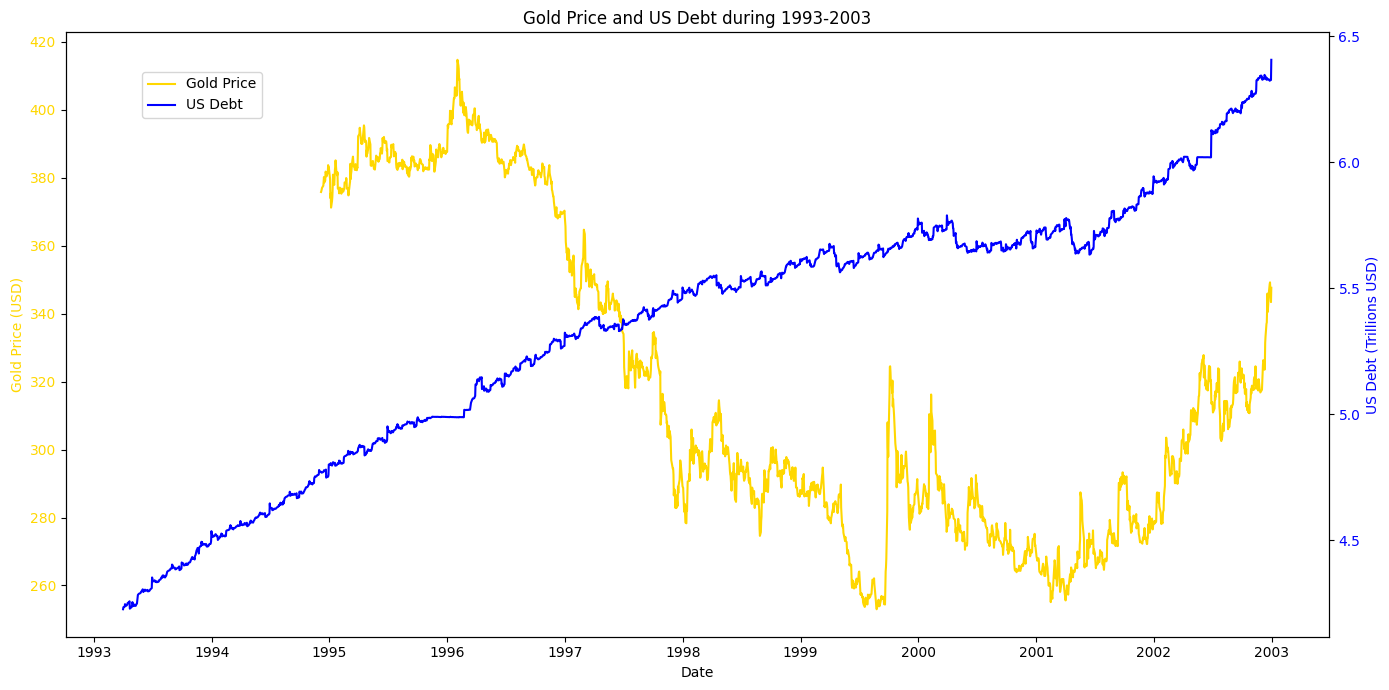

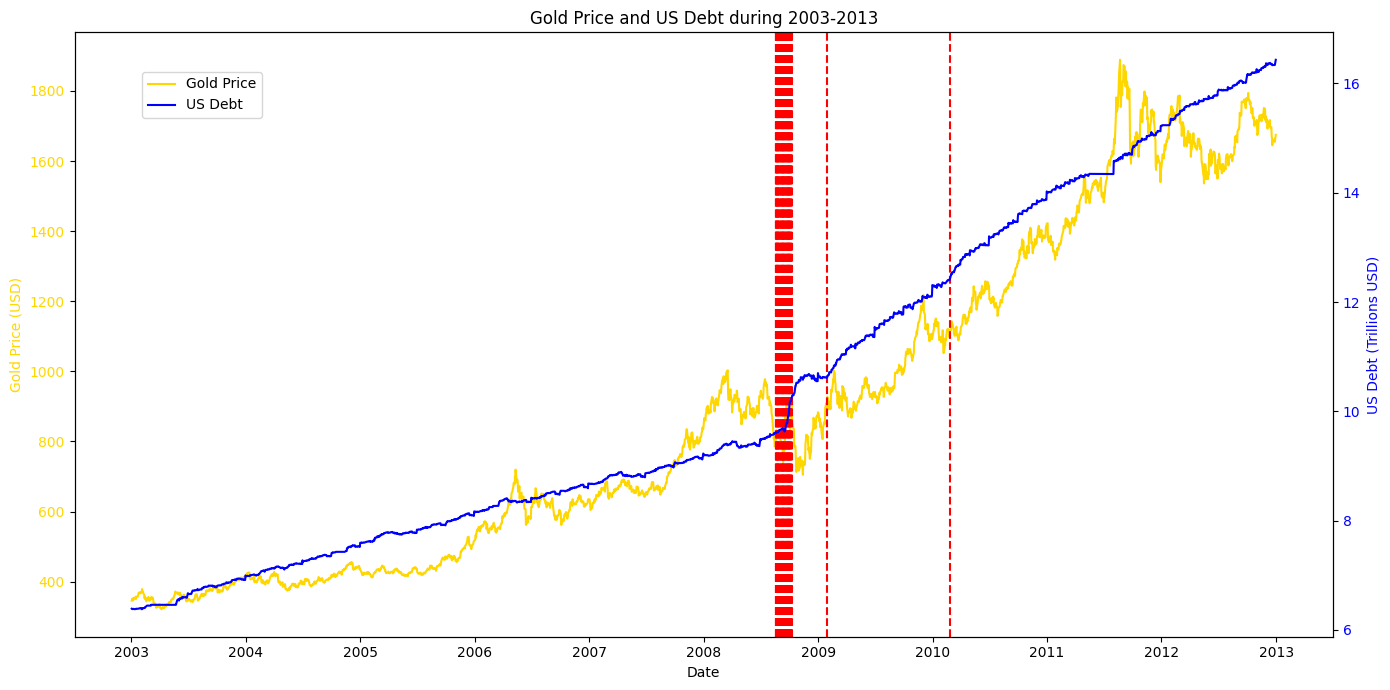

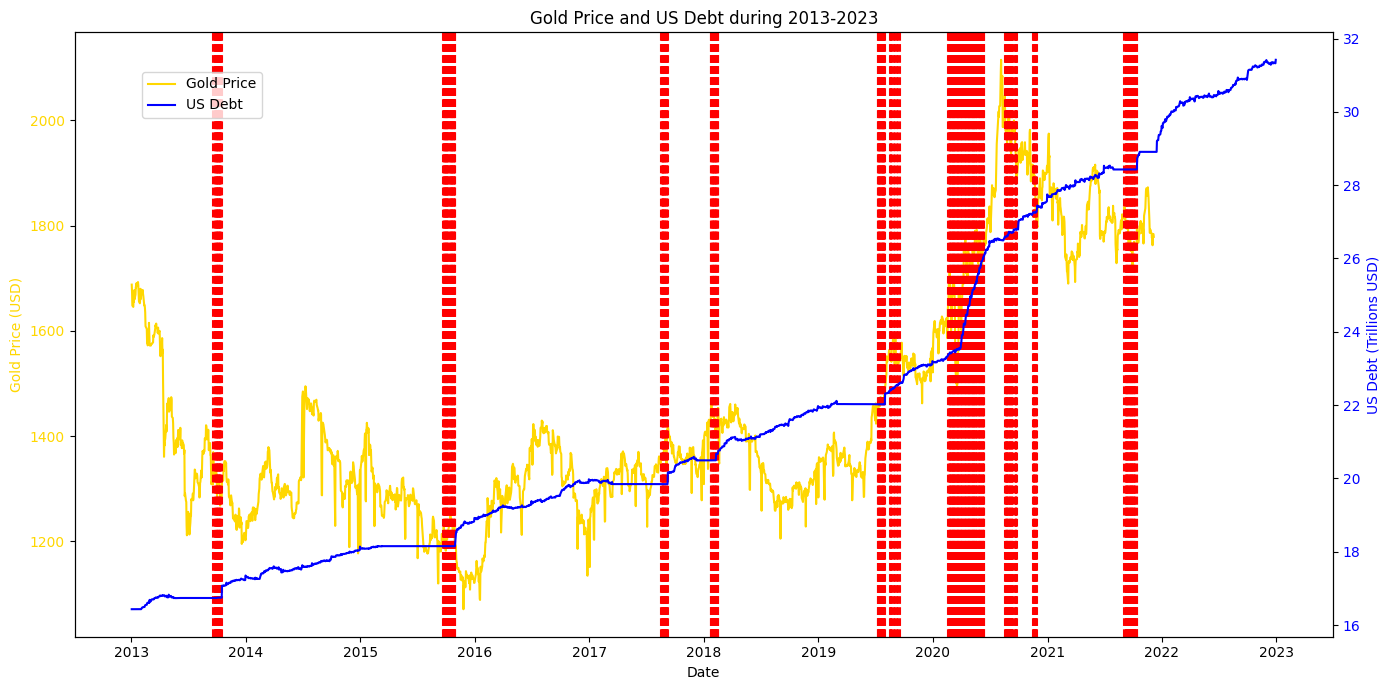

In [80]:
# Plots gold_data and debt_data aside put vertical red line when target is surendettement

def plot_aside_3(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.plot(gold_data[start_date:end_date].index, gold_data[start_date:end_date]['gold_price'], color='gold', label='Gold Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Price (USD)', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_data[start_date:end_date].index, debt_data[start_date:end_date]['debt_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Gold Price and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Add vertical lines for surendettement if the surrounding data is in the period
    surendettement_dates = data[data['target'] == 'surendettement'].index
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    for date in surendettement_dates:
        if start_date < date < end_date:
            ax1.axvline(date, color='red', linestyle='--')
    plt.show()

# Example usage

for period_name, (start_date, end_date) in decenal_periods.items():
    plot_aside_3(start_date=start_date, end_date=end_date, crisis_periods=period_name)

In [78]:

# Entraînement d'un modèle de classification de type Gradient Boosting avec GridSearchCV

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialisation du modèle
model = GradientBoostingClassifier(random_state=42)

# Initialisation de GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = grid_search.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred))



                precision    recall  f1-score   support

   endettement       0.92      0.98      0.95       867
 remboursement       0.87      0.71      0.78       167
surendettement       0.94      0.59      0.73        56

      accuracy                           0.92      1090
     macro avg       0.91      0.76      0.82      1090
  weighted avg       0.92      0.92      0.91      1090



Attention chaque grid search peut prendre plusieurs minutes dans le Gradient Boosting précédent on a mis plus de 6mn 

In [ ]:

# Définition des modèles et des grilles de paramètres
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(),
    'NeuralNetwork': MLPClassifier()
}

param_grids = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'NeuralNetwork': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred))

# Stratégie de trading (exemple simplifié)
def trading_strategy(predictions):
    for i, pred in enumerate(predictions):
        if pred == 'surendettement':
            print(f"Day {i}: Long position on US debt")
        elif pred == 'end':
            print(f"Day {i}: Short position on US debt")

# Prédictions et stratégie
predictions = grid_search.predict(X_test)
trading_strategy(predictions)

#### Next Step

- **Transformation des données et feature augmentation** : rajouter des features notamment liées à `debt_amt`. Aussi, on peut chercher à transformer nos données (``gold price`` ``inflation-ajusted``, ``debt_amt`` déflaté du ``GDP`` ou GDP/hab)
- **Analyse de la saisonnalité** : Étudier les effets saisonniers sur les prix de l'or et la dette américaine -> faire varier l'échelle des données (jusque-là on travaillait avec du daily mais comme on l'a vu dans la partie Granger Causality, il peut être intéressant de revenir à du ``weekly`` ou du ``monthly``)
- **Incorporation des données macroéconomiques** : Ajouter des indicateurs macroéconomiques disponible grâce à l'API tels que le ``taux de chômage``, ``l'inflation`` (TIPS and CPI), et les ``taux d'intérêt`` pour améliorer les prédictions.
- **Backtesting des stratégies de trading** : Mettre en place un environnement de backtesting pour évaluer les performances des stratégies de trading basées sur les modèles prédictifs.
- **Optimisation des hyperparamètres** : Une fois qu'on sait entraîner puis tester les performances d'un modèle, il nous reste à chercher les paramètres `x` et `s` optimaux.
- **De la classification à la regression (logistique)**